# Курсовой проект для курса "Python для Data Science"
## Задание:
Используя данные из train.csv, построить модель для предсказания цен на недвижимость (квартиры). С помощью полученной модели предсказать цены для квартир из файла test.csv.

## Целевая переменная:
Price

## Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

## Сдача проекта:
1. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту") ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook  с расширением ipynb). (Pull request не нужен, только ссылка ведущая на сам скрипт).
2. Приложить файл с названием по образцу SShirkin_predictions.csv с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price). В файле с предсказаниями должна быть 5001 строка (шапка + 5000 предсказаний).

## Сроки и условия сдачи:
Дедлайн: сдать проект нужно в течение 72 часов после начала Урока 10 ("Вебинар. Консультация по итоговому проекту").
Для успешной сдачи должны быть все предсказания (для 5000 квартир) и R2 должен быть больше 0.6.
При сдаче до дедлайна результат проекта может попасть в топ лучших результатов.
Повторная сдача и проверка результатов возможны только при условии предыдущей неуспешной сдачи.
Успешный проект нельзя пересдать в целях повышения результата.
Проекты, сданные после дедлайна или сданные повторно, не попадают в топ лучших результатов, но можно узнать результат.
В качестве итогового результата берется первый успешный результат, последующие успешные результаты не учитываются.

## Примечания:
Все файлы csv должны содержать названия полей (header - то есть "шапку"), разделитель - запятая.
В файлах не должны содержаться индексы из датафрейма.
Самая сложная из допустимых моделей - RandomForestRegressor из sklearn.

# Импорт данных

In [95]:
import numpy as np
import pandas as pd
import seaborn as sns
%config IPCompleter.greedy=True
%config InlineBackend.figure_format = 'jpeg'
%matplotlib inline
pd.options.display.max_columns = 100

In [2]:
csv_data = pd.read_csv('train.csv')
csv_data.head(3)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524


In [3]:
csv_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


# One Hot Encoding

In [4]:
print('Ecology_2 unique:', csv_data['Ecology_2'].unique())
print('Ecology_3 unique:', csv_data['Ecology_3'].unique())
print('Shops_2 unique:', csv_data['Shops_2'].unique())

Ecology_2 unique: ['B' 'A']
Ecology_3 unique: ['B' 'A']
Shops_2 unique: ['B' 'A']


In [440]:
data = pd.get_dummies(csv_data, columns=['Ecology_2', 'Ecology_3', 'Shops_2'])
tmp_filter = ((data['LifeSquare'].notna()) & (data['LifeSquare'] > data['Square']))
tmp_lifesquare = data.loc[tmp_filter, 'LifeSquare']
tmp_square = data.loc[tmp_filter, 'Square']
data.loc[tmp_filter, 'LifeSquare'] = tmp_square
data.loc[tmp_filter, 'Square'] = tmp_lifesquare
data.head(3)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,33,7976,5,NaN,0,11,184966.930730,0,1,0,1,0,1
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,46,10309,1,240.0,1,16,300009.450063,0,1,0,1,0,1
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,34,7759,0,229.0,1,3,220925.908524,0,1,0,1,0,1


In [436]:
data.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,57.223484,36.048753,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399,0.009700,0.990300,0.027500,0.972500,0.082500,0.917500
std,4859.01902,43.587592,0.839512,77.309420,19.372398,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865,0.098015,0.098015,0.163543,0.163543,0.275139,0.275139
min,0.00000,0.000000,0.000000,2.377248,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4169.50000,20.000000,1.000000,41.866858,22.765174,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
50%,8394.50000,36.000000,2.000000,52.633651,32.760108,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
75%,12592.50000,75.000000,2.000000,66.004634,45.029599,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,16798.00000,209.000000,19.000000,7480.592129,638.163193,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Корелляция

In [439]:
full_corr = data.corr()
perceptible_corr = full_corr.where((np.abs(full_corr) > 0.1) & (np.abs(full_corr) < 1))
perceptible_corr

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
Id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DistrictId,NaN,NaN,NaN,NaN,NaN,NaN,-0.120373,-0.149051,NaN,NaN,0.246463,0.167479,0.136095,0.304335,0.306147,0.174214,0.265100,NaN,NaN,NaN,NaN,NaN,NaN
Rooms,NaN,NaN,NaN,0.662893,0.131336,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.550291,NaN,NaN,NaN,NaN,NaN,NaN
Square,NaN,NaN,0.662893,NaN,0.196129,NaN,0.114791,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.520075,NaN,NaN,NaN,NaN,NaN,NaN
LifeSquare,NaN,NaN,0.131336,0.196129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
KitchenSquare,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Floor,NaN,-0.120373,NaN,0.114791,NaN,NaN,NaN,0.418986,NaN,NaN,NaN,NaN,NaN,-0.138294,NaN,NaN,0.128715,NaN,NaN,NaN,NaN,NaN,NaN
HouseFloor,NaN,-0.149051,NaN,NaN,NaN,NaN,0.418986,NaN,NaN,NaN,NaN,NaN,NaN,-0.143973,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HouseYear,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ecology_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.124068,NaN,NaN,NaN,NaN,0.110725,-0.110725,0.223197,-0.223197,NaN,NaN


Колонки, влияющие на цену

In [443]:
price_corr_columns = perceptible_corr[['Price']].dropna().sort_values('Price', ascending=False)
print(price_corr_columns.index.values)
price_corr_columns

['Rooms' 'LifeSquare' 'DistrictId' 'Social_1' 'Helthcare_2' 'Social_2'
 'Shops_1' 'Square' 'Healthcare_1' 'Floor']


,Price
Rooms,0.550291
LifeSquare,0.363570
DistrictId,0.265100
Social_1,0.263286
Helthcare_2,0.253090
Social_2,0.239226
Shops_1,0.180876
Square,0.142499
Healthcare_1,0.138755
Floor,0.128715


# Выбросы

## 'Rooms' и 'Square'

Исследуем 'Rooms' и 'Square' как самые сильные признаки для Price.

In [9]:
data['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

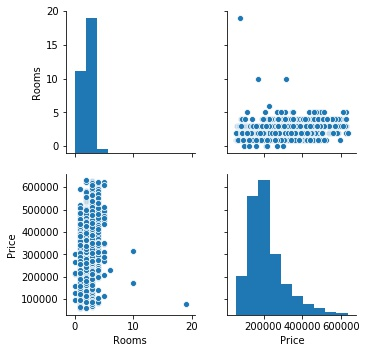

In [96]:
sns.pairplot(data.loc[:, ['Rooms', 'Price']])

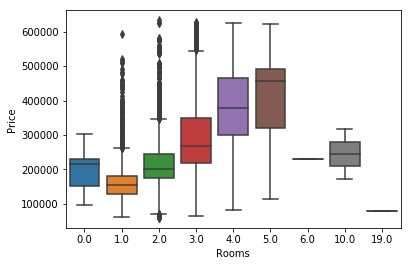

In [97]:
sns.boxplot(data['Rooms'], data['Price'])

Из графиков видно, что самые чистые данные находятся для 1 <= Rooms <= 5 в пределах 1 и 3 квартилей

In [80]:
rooms_quantiles = data.where((data['Rooms'] >= 1) & ((data['Rooms'] <= 5))) \
.groupby('Rooms')[['Price']] \
.quantile(q=[0.25, 0.75], interpolation='nearest')
rooms_quantiles

Price
Rooms                    
1.0   0.25  128711.103732
      0.75  182212.201038
2.0   0.25  174523.257872
      0.75  243479.876105
3.0   0.25  218500.747041
      0.75  349768.675634
4.0   0.25  298885.660186
      0.75  465934.434276
5.0   0.25  310305.074733
      0.75  496026.671162

### Отфильтруем датасет, получив подмножество с идеальным отношением 'Rooms' <-> 'Price'

In [178]:
room_frames = []
for i in range(1, 6):
    room_frames.append(data[['Id', 'Rooms', 'Square', 'Price']].where(
        (data['Rooms'] == i) &
        (data['Price'] >= rooms_quantiles.loc[i, 0.25].values[0] - 100) & 
        (data['Price'] <= rooms_quantiles.loc[i, 0.75].values[0] + 100)
    ).dropna())
ideal_rooms_data = pd.concat(room_frames)
print(ideal_rooms_data.count())
ideal_rooms_data['Rooms'].value_counts()

Id        5015
Rooms     5015
Square    5015
Price     5015
dtype: int64


2.0    1946
1.0    1860
3.0    1123
4.0      76
5.0      10
Name: Rooms, dtype: int64

### Фильтруем дальше, чтобы получить подмножество с идеальным отношением 'Rooms' <-> 'Square' <-> 'Price'

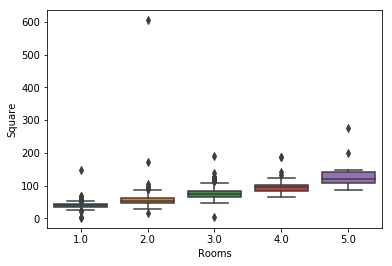

In [444]:
sns.boxplot(ideal_rooms_data['Rooms'], ideal_rooms_data['Square'])

In [445]:
square_quantiles = ideal_rooms_data.groupby('Rooms')[['Square']].quantile(q=[0.25, 0.75], interpolation='nearest')
square_quantiles

Square
Rooms                 
1.0   0.25   35.781532
      0.75   43.112986
2.0   0.25   46.245106
      0.75   62.838694
3.0   0.25   63.868017
      0.75   82.511146
4.0   0.25   82.945530
      0.75  101.828090
5.0   0.25  108.057398
      0.75  147.709302

Id        2979
Rooms     2979
Square    2979
Price     2979
dtype: int64

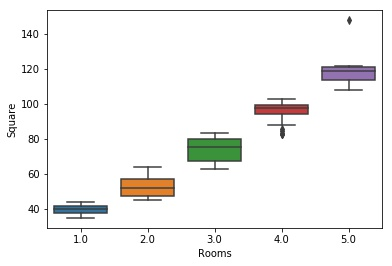

In [446]:
square_frames = []
for i in range(1, 6):
    square_frames.append(ideal_rooms_data.where(
        (ideal_rooms_data['Rooms'] == i) &
        (ideal_rooms_data['Square'] >= square_quantiles.loc[i, 0.25].values[0] - 1) & 
        (ideal_rooms_data['Square'] <= square_quantiles.loc[i, 0.75].values[0] + 1)
    ).dropna())
ideal_square_data = pd.concat(square_frames)
sns.boxplot(ideal_square_data['Rooms'], ideal_square_data['Square'])
ideal_square_data.count()

In [447]:
ideal_square_data.corr()

,Id,Rooms,Square,Price
Id,1.000000,-0.013533,-0.007883,-0.003490
Rooms,-0.013533,1.000000,0.930249,0.888783
Square,-0.007883,0.930249,1.000000,0.847623
Price,-0.003490,0.888783,0.847623,1.000000


### Строим модель для фиксов 'Square'

In [448]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
clf_square = GridSearchCV(estimator=RandomForestRegressor(random_state=42), 
                          param_grid=[{'n_estimators': [200, 250, 300], 'max_depth': [3, 5, 7]}],
                          cv=5)
clf_square.fit(
    ideal_square_data.loc[:, ideal_square_data.columns.isin(['Rooms', 'Price'])], 
    ideal_square_data.loc[:, ideal_square_data.columns == 'Square'].values.ravel(), 
)
clf_square.best_params_

{'max_depth': 5, 'n_estimators': 250}

In [449]:
for mean, std, params in zip(clf_square.cv_results_['mean_test_score'], clf_square.cv_results_['std_test_score'], clf_square.cv_results_['params']):
    print("%0.4f (±%0.4f) for %r" % (mean, std * 2, params))

0.2543 (±0.6439) for {'max_depth': 3, 'n_estimators': 200}
0.2550 (±0.6424) for {'max_depth': 3, 'n_estimators': 250}
0.2549 (±0.6427) for {'max_depth': 3, 'n_estimators': 300}
0.2564 (±0.6382) for {'max_depth': 5, 'n_estimators': 200}
0.2568 (±0.6373) for {'max_depth': 5, 'n_estimators': 250}
0.2566 (±0.6373) for {'max_depth': 5, 'n_estimators': 300}
0.2429 (±0.6458) for {'max_depth': 7, 'n_estimators': 200}
0.2431 (±0.6451) for {'max_depth': 7, 'n_estimators': 250}
0.2429 (±0.6448) for {'max_depth': 7, 'n_estimators': 300}


In [450]:
data_fixed_square = data.where(~data['Id'].isin(ideal_square_data['Id'])).dropna(how='all')
data_fixed_square['Square'] = clf_square.predict(data_fixed_square.loc[:, data_fixed_square.columns.isin(['Rooms', 'Price'])])

### Строим модель для фиксов 'Room'

In [452]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
clf_rooms = GridSearchCV(estimator=RandomForestRegressor(random_state=42), 
                          param_grid=[{'n_estimators': [200, 250, 300], 'max_depth': [3, 5, 7]}],
                          cv=5)
clf_rooms.fit(
    ideal_square_data.loc[:, ideal_square_data.columns.isin(['Square', 'Price'])], 
    ideal_square_data.loc[:, ideal_square_data.columns == 'Rooms'].values.ravel(), 
)
clf_rooms.best_params_

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'max_depth': 5, 'n_estimators': 200}

In [454]:
for mean, std, params in zip(clf_rooms.cv_results_['mean_test_score'], clf_rooms.cv_results_['std_test_score'], clf_rooms.cv_results_['params']):
    print("%0.4f (±%0.4f) for %r" % (mean, std * 2, params))

0.5204 (±1.1504) for {'max_depth': 3, 'n_estimators': 200}
0.5204 (±1.1509) for {'max_depth': 3, 'n_estimators': 250}
0.5203 (±1.1513) for {'max_depth': 3, 'n_estimators': 300}
0.5270 (±1.1535) for {'max_depth': 5, 'n_estimators': 200}
0.5266 (±1.1549) for {'max_depth': 5, 'n_estimators': 250}
0.5265 (±1.1553) for {'max_depth': 5, 'n_estimators': 300}
0.5264 (±1.1526) for {'max_depth': 7, 'n_estimators': 200}
0.5259 (±1.1538) for {'max_depth': 7, 'n_estimators': 250}
0.5258 (±1.1542) for {'max_depth': 7, 'n_estimators': 300}


In [455]:
data_fixed_rooms = data.where(~data['Id'].isin(ideal_square_data['Id'])).dropna(how='all')
data_fixed_rooms['Rooms'] = clf_rooms.predict(data_fixed_rooms.loc[:, data_fixed_rooms.columns.isin(['Square', 'Price'])])

## Выбросы 'LifeSquare'

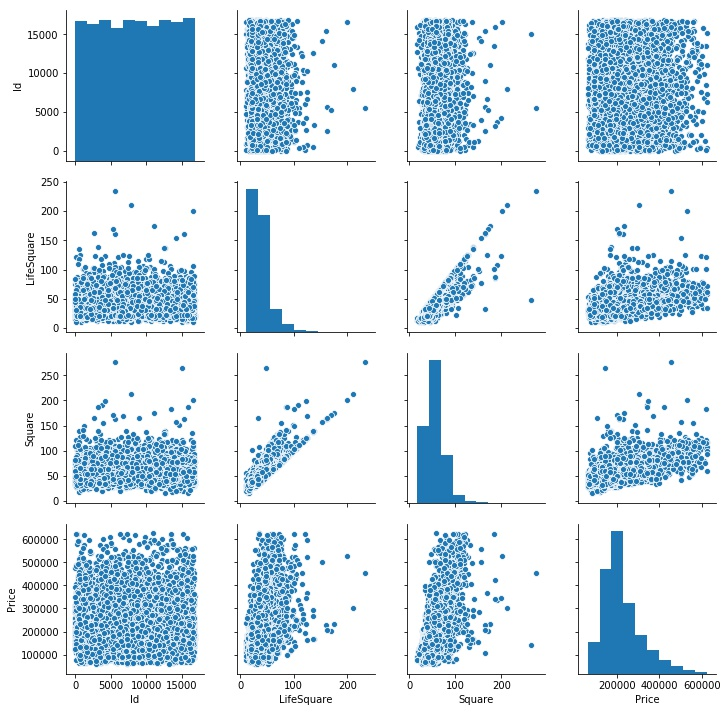

In [457]:
ideal_lifesquare_sample = data.loc[
    (data['LifeSquare'].notna()) & 
    (data['LifeSquare'] < 400) & 
    (data['Square'] < 400) & 
    (data['LifeSquare'] > 10), 
    ['Id', 'LifeSquare', 'Square', 'Price']
]
# tmp_lifesquare = ideal_lifesquare_sample.loc[(data['LifeSquare'] > data['Square']), 'LifeSquare']
# tmp_square = ideal_lifesquare_sample.loc[(data['LifeSquare'] > data['Square']), 'Square']
# ideal_lifesquare_sample.loc[(data['LifeSquare'] > data['Square']), 'LifeSquare'] = tmp_square
# ideal_lifesquare_sample.loc[(data['LifeSquare'] > data['Square']), 'Square'] = tmp_lifesquare
sns.pairplot(ideal_lifesquare_sample)

In [458]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
clf_life_square = GridSearchCV(estimator=RandomForestRegressor(random_state=42), 
                          param_grid=[{'n_estimators': [200, 250, 300], 'max_depth': [3, 5, 7]}],
                          cv=5)
clf_life_square.fit(
    ideal_lifesquare_sample.loc[:, ideal_lifesquare_sample.columns.isin(['Square', 'Price'])], 
    ideal_lifesquare_sample.loc[:, ideal_lifesquare_sample.columns == 'LifeSquare'].values.ravel(), 
)
clf_life_square.best_params_

{'max_depth': 7, 'n_estimators': 200}

In [459]:
for mean, std, params in zip(clf_life_square.cv_results_['mean_test_score'], clf_life_square.cv_results_['std_test_score'], clf_life_square.cv_results_['params']):
    print("%0.4f (±%0.4f) for %r" % (mean, std * 2, params))

0.6852 (±0.0259) for {'max_depth': 3, 'n_estimators': 200}
0.6850 (±0.0256) for {'max_depth': 3, 'n_estimators': 250}
0.6853 (±0.0253) for {'max_depth': 3, 'n_estimators': 300}
0.7299 (±0.0264) for {'max_depth': 5, 'n_estimators': 200}
0.7294 (±0.0260) for {'max_depth': 5, 'n_estimators': 250}
0.7291 (±0.0265) for {'max_depth': 5, 'n_estimators': 300}
0.7335 (±0.0317) for {'max_depth': 7, 'n_estimators': 200}
0.7331 (±0.0314) for {'max_depth': 7, 'n_estimators': 250}
0.7329 (±0.0316) for {'max_depth': 7, 'n_estimators': 300}


In [460]:
data_fixed_life_square = data.where(~data['Id'].isin(ideal_lifesquare_sample['Id'])).dropna(how='all')
data_fixed_life_square['LifeSquare'] = clf_life_square.predict(data_fixed_life_square.loc[:, data_fixed_life_square.columns.isin(['Square', 'Price'])])

# Собираем итоговый датафрейм

In [467]:
data_final = data.copy()
# исправляем Square
print('Корелляция Square⇔Price до фиксов', data_final.corr()['Square']['Price'])
data_final.loc[data_final['Id'].isin(data_fixed_square['Id']), 'Square'] = data_fixed_square['Square']
print('Корелляция Square⇔Price после фиксов', data_final.corr()['Square']['Price'])
# исправляем Rooms
print('Корелляция Rooms⇔Price до фиксов', data_final.corr()['Rooms']['Price'])
data_final.loc[data_final['Id'].isin(data_fixed_rooms['Id']), 'Rooms'] = data_fixed_rooms['Rooms']
print('Корелляция Rooms⇔Price после фиксов', data_final.corr()['Rooms']['Price'])
# исправляем LifeSquare
print('Корелляция LifeSquare⇔Price до фиксов', data_final.corr()['LifeSquare']['Price'])
print('Корелляция LifeSquare⇔Square до фиксов', data_final.corr()['LifeSquare']['Square'])
data_final.loc[data_final['Id'].isin(data_fixed_life_square['Id']), 'LifeSquare'] = data_fixed_life_square['LifeSquare']
print('Корелляция LifeSquare⇔Price после фиксов', data_final.corr()['LifeSquare']['Price'])
print('Корелляция LifeSquare⇔Square после фиксов', data_final.corr()['LifeSquare']['Square'])
# исправляем HouseYear
data_final.loc[(data_final['HouseYear'] < 1900) | (data_final['HouseYear'] > 2020), 'HouseYear'] = data['HouseYear'].median()
# исправляем Healthcare_1
data_final['Healthcare_1'] = data_final['Healthcare_1'].fillna(-999)

Корелляция Square⇔Price до фиксов 0.14249926312014716
Корелляция Square⇔Price после фиксов 0.5785649013661918
Корелляция Rooms⇔Price до фиксов 0.5502907269258719
Корелляция Rooms⇔Price после фиксов 0.6990166470705452
Корелляция LifeSquare⇔Price до фиксов 0.36356966846690975
Корелляция LifeSquare⇔Square до фиксов 0.5572376558595759
Корелляция LifeSquare⇔Price после фиксов 0.3764463994519796
Корелляция LifeSquare⇔Square после фиксов 0.6349765319950615


# Предсказание
Наблюдаем за изменением главной метрики

In [462]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
x_train, x_test, y_train, y_test = train_test_split(
    data_final.loc[:, ~data_final.columns.isin(['Id', 'Price'])], 
    data.loc[:, data.columns == 'Price'], 
    test_size=0.25, 
    random_state=42
)

In [463]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
print('Начальное значение:', 0.45173783173008786)
r2_score(y_test, y_pred)

Начальное значение: 0.45173783173008786


0.614996013012864

In [464]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(random_state=42, max_depth=9)
dtr.fit(x_train, y_train)
y_pred = dtr.predict(x_test)
print('Начальное значение:', 0.6353812140583176)
r2_score(y_test, y_pred)

Начальное значение: 0.6353812140583176


0.8936330322957861

In [401]:
data_final.loc[:, ~data_final.columns.isin(['Id', 'Price'])].columns

Index(['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor',
       'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2',
       'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Ecology_2_A',
       'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B', 'Shops_2_A', 'Shops_2_B'],
      dtype='object')

In [465]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
clf_final = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42), 
    param_grid=[{'n_estimators': [100], 
                 'max_depth': [11, 13]}],
    cv=5
)
clf_final.fit(
    data_final.loc[:, ~data_final.columns.isin(['Id', 'Price', 'LifeSquare'])], 
    data_final.loc[:, data_final.columns == 'Price'].values.ravel(), 
)
clf_final.best_params_

{'max_depth': 13, 'n_estimators': 100}

In [466]:
for mean, std, params in zip(clf_final.cv_results_['mean_test_score'], clf_final.cv_results_['std_test_score'], clf_final.cv_results_['params']):
    print("%0.4f (±%0.4f) for %r" % (mean, std * 2, params))

0.9207 (±0.0202) for {'max_depth': 11, 'n_estimators': 100}
0.9224 (±0.0200) for {'max_depth': 13, 'n_estimators': 100}
